**Stress Prediction [XGBoost | Optuna | SHAP]**

In [84]:
# pip install kagglehub[pandas-datasets] matplotlib plotly optuna shap xgboost

In [85]:
import kagglehub
import numpy as np
import optuna
import pandas as pd
import plotly
import shap
from kagglehub import KaggleDatasetAdapter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier

**1. Wczytanie danych**

In [86]:
file_path = "stress_detection_data.csv"

df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shijo96john/stress-level-prediction",
  file_path,
)

pd.set_option('display.max_columns', None)

df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Wake_Up_Time,Bed_Time,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection
0,30,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
1,35,Female,Marketing Manager,Married,6.0,3.0,6:00 AM,11:00 PM,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,Medium
2,40,Male,Data Scientist,Divorced,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,High
3,35,Male,Software Engineer,Single,7.0,4.0,7:00 AM,10:00 PM,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,Low
4,29,Female,Teacher,Single,8.0,5.0,6:30 AM,10:30 PM,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,Low


**2. Feature Engineering / EDA**

In [87]:
df.isnull().sum()

Age                    0
Gender                 0
Occupation             0
Marital_Status         0
Sleep_Duration         0
Sleep_Quality          0
Wake_Up_Time           0
Bed_Time               0
Physical_Activity      0
Screen_Time            0
Caffeine_Intake        0
Alcohol_Intake         0
Smoking_Habit          0
Work_Hours             0
Travel_Time            0
Social_Interactions    0
Meditation_Practice    0
Exercise_Type          0
Blood_Pressure         0
Cholesterol_Level      0
Blood_Sugar_Level      0
Stress_Detection       0
dtype: int64

In [88]:
df.describe()

,Age,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Work_Hours,Travel_Time,Social_Interactions,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level
count,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000,773.000000
mean,38.887451,6.338422,3.848124,2.979301,4.105433,1.818887,0.888745,8.258732,2.858344,3.196636,137.943079,220.834411,111.765847
std,7.686642,0.733584,0.545459,0.797234,0.812513,0.838396,0.673741,1.064168,1.083758,0.856332,13.122060,19.322622,12.533097
min,18.000000,3.500000,2.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.500000,1.000000,110.000000,150.000000,80.000000
25%,33.000000,6.000000,3.600000,2.000000,4.000000,1.000000,0.000000,8.000000,2.000000,3.000000,130.000000,210.000000,105.000000
50%,39.000000,6.300000,3.900000,3.000000,4.000000,2.000000,1.000000,8.000000,3.000000,3.000000,140.000000,220.000000,115.000000
75%,45.000000,7.000000,4.000000,4.000000,5.000000,2.000000,1.000000,9.000000,4.000000,4.000000,150.000000,230.000000,120.000000
max,60.000000,8.000000,5.000000,5.000000,8.000000,4.000000,2.000000,14.000000,5.000000,5.000000,170.000000,290.000000,150.000000


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  773 non-null    int64  
 1   Gender               773 non-null    object 
 2   Occupation           773 non-null    object 
 3   Marital_Status       773 non-null    object 
 4   Sleep_Duration       773 non-null    float64
 5   Sleep_Quality        773 non-null    float64
 6   Wake_Up_Time         773 non-null    object 
 7   Bed_Time             773 non-null    object 
 8   Physical_Activity    773 non-null    float64
 9   Screen_Time          773 non-null    float64
 10  Caffeine_Intake      773 non-null    int64  
 11  Alcohol_Intake       773 non-null    int64  
 12  Smoking_Habit        773 non-null    object 
 13  Work_Hours           773 non-null    int64  
 14  Travel_Time          773 non-null    float64
 15  Social_Interactions  773 non-null    int

In [90]:
STRESS_LEVEL_TO_LABEL = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}
LABEL_TO_STRESS_LEVEL = {v: k for k, v in STRESS_LEVEL_TO_LABEL.items()}

df['Stress_Detection'] = df['Stress_Detection'].map(STRESS_LEVEL_TO_LABEL)

In [91]:
def time_to_float(time_str):
    time_str = time_str.replace("AM", "").replace("PM", "").strip()
    hours, minutes = map(int, time_str.split(":"))
    return hours + minutes/60

df["Bed_Time"] = df["Bed_Time"].astype(str)
df["Wake_Up_Time"] = df["Wake_Up_Time"].astype(str)
df["Bed_Time_float"] = df["Bed_Time"].apply(time_to_float)
df["Wake_Up_Time_float"] = df["Wake_Up_Time"].apply(time_to_float)
df["Bed_Time_sin"] = np.sin(2 * np.pi * df["Bed_Time_float"] / 24)
df["Bed_Time_cos"] = np.cos(2 * np.pi * df["Bed_Time_float"] / 24)
df["Wake_Up_Time_sin"] = np.sin(2 * np.pi * df["Wake_Up_Time_float"] / 24)
df["Wake_Up_Time_cos"] = np.cos(2 * np.pi * df["Wake_Up_Time_float"] / 24)

columns_to_drop = ["Bed_Time", "Wake_Up_Time", "Bed_Time_float", "Wake_Up_Time_float"]
df = df.drop(columns=columns_to_drop)

In [92]:
df.head()

,Age,Gender,Occupation,Marital_Status,Sleep_Duration,Sleep_Quality,Physical_Activity,Screen_Time,Caffeine_Intake,Alcohol_Intake,Smoking_Habit,Work_Hours,Travel_Time,Social_Interactions,Meditation_Practice,Exercise_Type,Blood_Pressure,Cholesterol_Level,Blood_Sugar_Level,Stress_Detection,Bed_Time_sin,Bed_Time_cos,Wake_Up_Time_sin,Wake_Up_Time_cos
0,30,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
1,35,Female,Marketing Manager,Married,6.0,3.0,1.0,3.0,0,1,No,9,2.0,3,No,Yoga,110,160,80,1,0.258819,-0.965926,1.000000,6.123234e-17
2,40,Male,Data Scientist,Divorced,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Strength Training,130,200,100,2,0.500000,-0.866025,0.965926,-2.588190e-01
3,35,Male,Software Engineer,Single,7.0,4.0,2.0,4.0,1,0,No,8,1.0,5,Yes,Cardio,120,180,90,0,0.500000,-0.866025,0.965926,-2.588190e-01
4,29,Female,Teacher,Single,8.0,5.0,3.0,2.0,1,0,No,7,1.0,4,Yes,Yoga,110,180,90,0,0.382683,-0.923880,0.991445,-1.305262e-01


In [93]:
categorical_cols = [col for col in df.select_dtypes(include=['object']).columns]
print(categorical_cols)

for col in categorical_cols:
    df[col] = df[col].astype('category')

['Gender', 'Occupation', 'Marital_Status', 'Smoking_Habit', 'Meditation_Practice', 'Exercise_Type']


In [94]:
# TODO: Detect outliers
# TODO: Check class balance

**3. Modelowanie**

In [95]:
target = 'Stress_Detection'
X = df.drop(columns=[target])
y = df[target]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

model = XGBClassifier(enable_categorical=True)
model.fit(X_train, y_train)

print(model)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Accuracy: 71.48%


**4. Optymalizacja hiperparametrów (Optuna)**

In [96]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),  # default: 100
        'max_depth': trial.suggest_int('max_depth', 3, 10),  # default: 3
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # default: 1
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # default: 0.1
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # default: 1
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # default: 1
        'gamma': trial.suggest_float('gamma', 0, 5),  # default: 0
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # default: 0
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # default: 1
        'enable_categorical': True
    }
    
    clf = XGBClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # TODO: Memorize the reason behind using StratifiedKFold
    return cross_val_score(clf, X, y, n_jobs=-1, cv=skf).mean()


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=400)

trial = study.best_trial

print('Best Accuracy: {:.2f}%'.format(trial.value * 100))
print("Best hyperparameters: {}".format(trial.params))

[I 2025-11-23 11:19:08,548] A new study created in memory with name: no-name-ba620038-39a0-4573-b1a8-53e3f3a667a5
[I 2025-11-23 11:19:20,322] Trial 0 finished with value: 0.6248512777545036 and parameters: {'n_estimators': 265, 'max_depth': 5, 'min_child_weight': 5, 'learning_rate': 0.08638283330718806, 'subsample': 0.8936968554463132, 'colsample_bytree': 0.9935135338634444, 'gamma': 2.7874816188704763, 'reg_alpha': 9.568837039874392, 'reg_lambda': 4.911221325416513}. Best is trial 0 with value: 0.6248512777545036.
[I 2025-11-23 11:19:22,898] Trial 1 finished with value: 0.6222622538751571 and parameters: {'n_estimators': 93, 'max_depth': 5, 'min_child_weight': 3, 'learning_rate': 0.05902654918857394, 'subsample': 0.9824257837405189, 'colsample_bytree': 0.6047962683716487, 'gamma': 2.0840004219295762, 'reg_alpha': 9.41973637000378, 'reg_lambda': 7.43934859957792}. Best is trial 0 with value: 0.6248512777545036.
[I 2025-11-23 11:19:23,116] Trial 2 finished with value: 0.6403937997486384

Best Accuracy: 73.35%
Best hyperparameters: {'n_estimators': 76, 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.029555936401665754, 'subsample': 0.7845316700610873, 'colsample_bytree': 0.7231992631983248, 'gamma': 0.10745660805977918, 'reg_alpha': 0.03717472397773244, 'reg_lambda': 1.89017945925193}


In [97]:
# TODO: Resolve plotly import issue and choose one/two plots to display

# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_parallel_coordinate(study)

In [98]:
# TODO: Train the model with best hyperparameters

**5. Interpretacja rezultatów (SHAP + wykresy)**

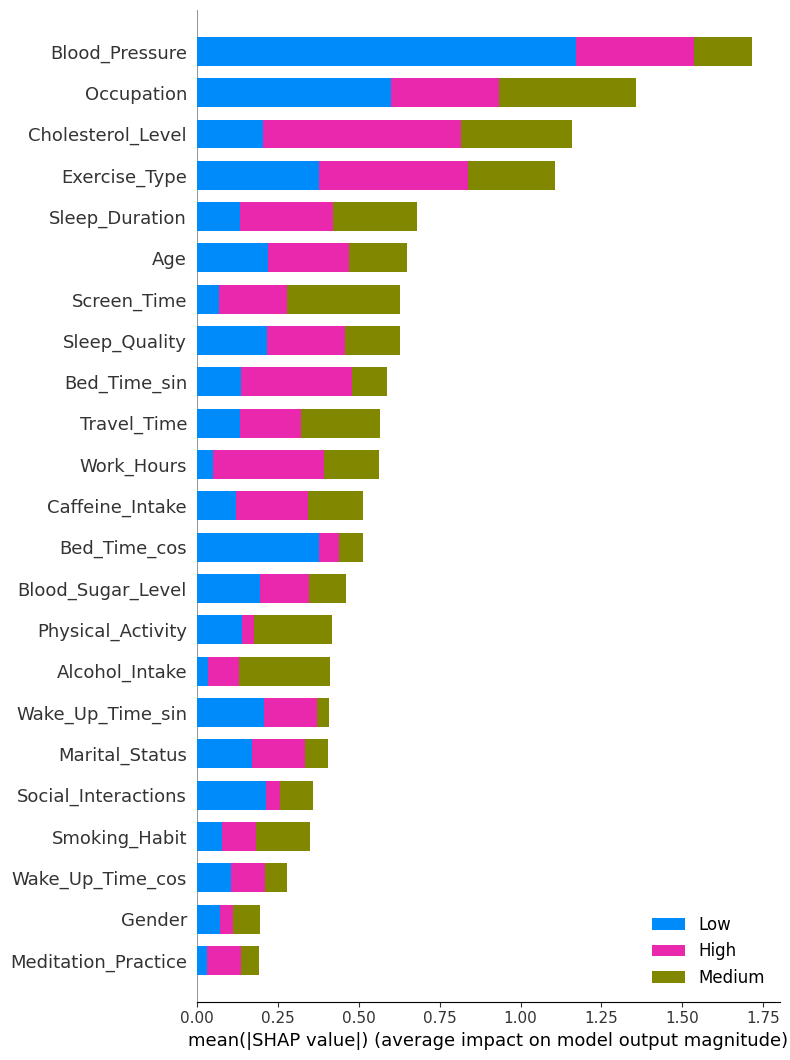

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=50,
                  class_names=[LABEL_TO_STRESS_LEVEL[i] for i in range(len(LABEL_TO_STRESS_LEVEL))]
                  )  # TODO: Preetify the plot and class names display order / change the plot type

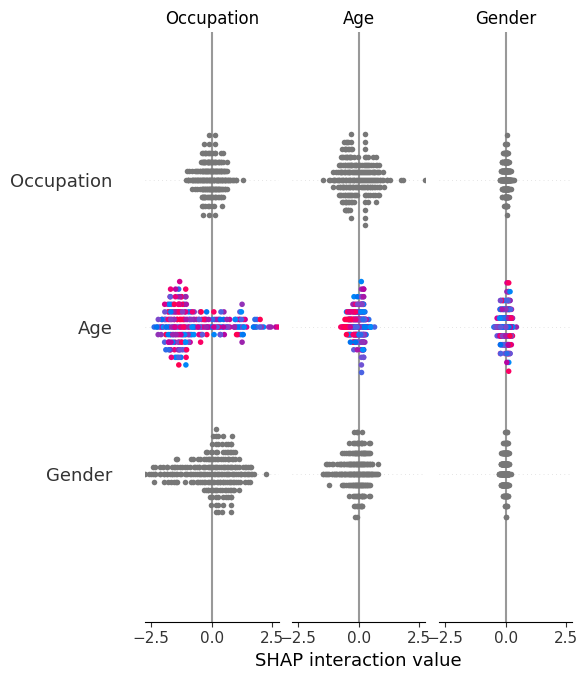

In [100]:
shap.summary_plot(shap_values, X_test)

In [103]:
print(X_test.columns.tolist())
print(shap_values[0].shape) 

['Age', 'Gender', 'Occupation', 'Marital_Status', 'Sleep_Duration', 'Sleep_Quality', 'Physical_Activity', 'Screen_Time', 'Caffeine_Intake', 'Alcohol_Intake', 'Smoking_Habit', 'Work_Hours', 'Travel_Time', 'Social_Interactions', 'Meditation_Practice', 'Exercise_Type', 'Blood_Pressure', 'Cholesterol_Level', 'Blood_Sugar_Level', 'Bed_Time_sin', 'Bed_Time_cos', 'Wake_Up_Time_sin', 'Wake_Up_Time_cos']
(23, 3)
